Movie dataset을 이용해서 데이터를 분석하는 포트폴리오입니다.  
Data에 대한 정보는  https://www.kaggle.com/rounakbanik/the-movies-dataset 의 데이터셋을 사용했습니다.  
아래부터는 Spark를 이용한 데이터 처리, Pandas를 이용한 데이터 분석, 알고리즘을 이용한 영화 추천 등을 해보았습니다.   

#1. Spark 설치 및, Spark를 이용한 데이터 처리 과정


In [ ]:
#spark 설치 및 기본 설정
!apt-get install openjdk-8-jdk-headless
!wget -q https://mirror.navercorp.com/apache/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar -xvf spark-3.1.2-bin-hadoop3.2.tgz
!pip install findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
import findspark
findspark.init()
import pyspark
spark = pyspark.sql.SparkSession.builder.appName("test").master("local[*]").getOrCreate()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jdk-headless is already the newest version (8u312-b07-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
spark-3.1.2-bin-hadoop3.2/
spark-3.1.2-bin-hadoop3.2/R/
spark-3.1.2-bin-hadoop3.2/R/lib/
spark-3.1.2-bin-hadoop3.2/R/lib/sparkr.zip
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/worker.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/daemon.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/testthat/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/testthat/test_basic.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/shell.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/general.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignette

In [ ]:
#데이터 원본 불러오기
path = '/content/drive/MyDrive/Colab_project/movie'
from pyspark.sql import SparkSession
sc = SparkSession.builder.master('local[*]').appName('hello').getOrCreate()
file_df = sc.read.csv(path + '/movies_metadata.csv', header = True)
print(file_df.head(10))
print((file_df.count(), len(file_df.columns)))

+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------+--------------------+-----------------+
|adult|belongs_to_collection|  budget|              genres|            homepage|   id|  imdb_id|original_language|      original_title|            overview|popularity|         poster_path|production_companies|production_countries|        release_date|             revenue|             runtime|    spoken_languages|  status|             tagline|               title|   video|        vote_average|       vote_count|
+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+--------------------+--------------------+----------+-----

In [ ]:
from pyspark.sql.functions import *

#각 데이터 형태에 맞게 변환
file_df = file_df.withColumn("vote_average", file_df["vote_average"].cast("float"))
file_df = file_df.withColumn("vote_count", file_df["vote_count"].cast("int"))
file_df = file_df.withColumn("id", file_df["id"].cast("int"))
file_df = file_df.withColumn("release_date", to_date(file_df["release_date"]))

#null 값은 filter을 통해서 제거
file_df = file_df.filter(col("vote_average").isNotNull())
file_df = file_df.filter(col("vote_count").isNotNull())
file_df = file_df.filter(col("id").isNotNull())
file_df = file_df.filter(col("release_date").isNotNull())

#필요없는 col 값들은 제거
file_df = file_df.select('belongs_to_collection', 'genres', 'id' , 'release_date','tagline','title','vote_average','vote_count')

print((file_df.count(), len(file_df.columns)))

(41489, 8)


In [ ]:
file_df.setNullableStateOfColumn(file_df,'')

In [ ]:
#속성 정보들 확인
file_df.printSchema()

root
 |-- belongs_to_collection: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- release_date: date (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: float (nullable = true)
 |-- vote_count: integer (nullable = true)



In [ ]:
#genres, collection을 dict 형태에서 list형태로 변환, 데이터 처리 후 Dataframe 확인
from ast import literal_eval

def get_genres(x):
  x = literal_eval(x)
  answer = []
  for i in x:
    answer.append(i['name'])
  return answer

def get_collection(x):
  try:
    x = literal_eval(x)
    return x['name']
  except:
    return None

from pyspark.sql.types import StringType

func_udf = udf(get_genres, StringType())
file_df = file_df.withColumn("genres", func_udf(file_df["genres"]))

func_udf = udf(get_collection, StringType())
file_df = file_df.withColumn("belongs_to_collection", func_udf(file_df["belongs_to_collection"]))
file_df.orderBy(col("id").asc()).show(10)

+---------------------+--------------------+---+------------+--------------------+-------------------+------------+----------+
|belongs_to_collection|              genres| id|release_date|             tagline|              title|vote_average|vote_count|
+---------------------+--------------------+---+------------+--------------------+-------------------+------------+----------+
|                 null|      [Drama, Crime]|  2|  1988-10-21|                null|              Ariel|         7.1|        44|
|                 null|     [Drama, Comedy]|  3|  1986-10-16|                null|Shadows in Paradise|         7.1|        35|
|                 null|     [Crime, Comedy]|  5|  1995-12-09|Twelve outrageous...|         Four Rooms|         6.5|       539|
|                 null|[Action, Thriller...|  6|  1993-10-15|Don't move. Don't...|     Judgment Night|         6.4|        79|
| Star Wars Collection|[Adventure, Actio...| 11|  1977-05-25|A long time ago i...|          Star Wars|         

In [ ]:
#평점 데이터 확인 및 timestamp 제거
rating_df = sc.read.csv(path + '/ratings_small.csv', header = True)
rating_df = rating_df.drop('timestamp')
rating_df.show(10)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|     31|   2.5|
|     1|   1029|   3.0|
|     1|   1061|   3.0|
|     1|   1129|   2.0|
|     1|   1172|   4.0|
|     1|   1263|   2.0|
|     1|   1287|   2.0|
|     1|   1293|   2.0|
|     1|   1339|   3.5|
|     1|   1343|   2.0|
+------+-------+------+
only showing top 10 rows



#2. 데이터 분석

In [ ]:
#데이터를 spark 형에서 pandas로 변환
import numpy as np
import pandas as pd
movie_df = file_df.select("*").toPandas()
rating_df = rating_df.select("*").toPandas()
movie_df.head(5)

,belongs_to_collection,genres,id,release_date,tagline,title,vote_average,vote_count
0,Toy Story Collection,"[Animation, Comedy, Family]",862,1995-10-30,None,Toy Story,7.7,5415
1,None,"[Adventure, Fantasy, Family]",8844,1995-12-15,Roll the dice and unleash the excitement!,Jumanji,6.9,2413
2,Grumpy Old Men Collection,"[Romance, Comedy]",15602,1995-12-22,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92
3,Father of the Bride Collection,[Comedy],11862,1995-02-10,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173
4,None,"[Action, Crime, Drama, Thriller]",949,1995-12-15,A Los Angeles Crime Saga,Heat,7.7,1886


In [ ]:
print('영화의 개수 : ', len(movie_df))
print('평점의 개수 : ', len(rating_df))

영화의 개수 :  41489
평점의 개수 :  100004


          count
Drama     18654
Comedy    11933
Thriller   7132


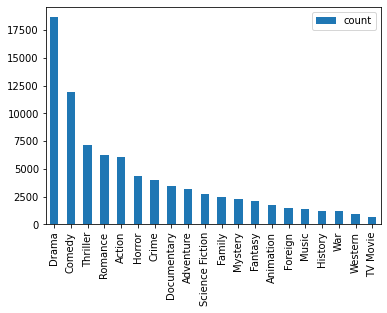

In [ ]:
#장르의 개수 확인
import yaml
genres_count = {}
for i in range(len(movie_df)):
    try:
      genres = movie_df.loc[i,'genres']
      genres = yaml.load(genres)
    except:
      continue
    for j in genres:
        if j not in genres_count:
            genres_count.update({j : 1})
        else:
            genres_count[j] += 1
data_gen = pd.DataFrame.from_dict([genres_count])
data_gen = data_gen.rename(index = {0 : 'count'})
data_gen = data_gen.T
data_gen = data_gen.sort_values(by = 'count',ascending= False)
print(data_gen.head(3))
data_gen.plot.bar()

     count
the   6389
a     4035
of    3637


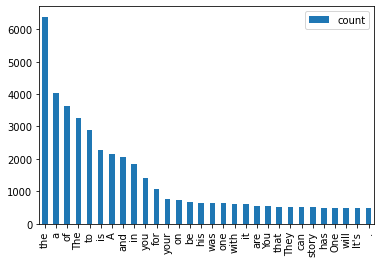

In [ ]:
#keyword의 단어 확인
keywords_count  = {}
for i in range(len(movie_df)):
    try:
      keywords = movie_df.loc[i,'tagline']
      keywords = keywords.split(" ")
    except:
      continue
    for j in keywords:
        if j not in keywords_count :
            keywords_count .update({j : 1})
        else:
            keywords_count [j] += 1
data_tag = pd.DataFrame.from_dict([keywords_count ])
data_tag = data_tag.rename(index = {0 : 'count'})
data_tag = data_tag.T
data_tag = data_tag.sort_values(by = 'count',ascending= False)
print(data_tag.head(3))
data_tag.head(30).plot.bar()

              belongs_to_collection  counts
1178                The Bowery Boys      28
611           James Bond Collection      26
1561  Zatôichi: The Blind Swordsman      25


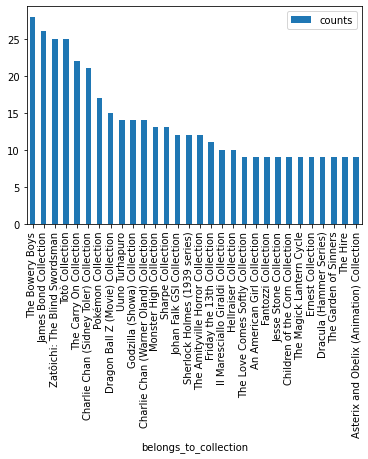

In [ ]:
#collection의 정보 개수 확인
collection_infor = movie_df.groupby('belongs_to_collection').size().reset_index(name='counts')
collection_infor = collection_infor.sort_values(by = 'counts' , ascending= False)
print(collection_infor.head(3))
collection_infor.head(30).plot(x = 'belongs_to_collection', kind="bar")

# 3 평점 순 영화 추천

영화 평점의 경우 단순한 평점이 아닌 IMDB의 계산 방식을 따랐습니다.  
평점 개수가 1개인 영화와 평점 개수가 여러 개인 영화의 평점은 가중치를 다르게 설정하여 계산한 방식으로, 평점이 1개인데 10점인 영화가 맨위에 오는 것을 막아주는 용도입니다.  
상위 10퍼의 평점 개수를 측정하여 커트라인을 만들고, 영화 평점 개수에 따라 평점에 가중치를 두어서 새롭게 계산했습니다.


In [ ]:
C= movie_df['vote_average'].mean()
m= movie_df['vote_count'].quantile(0.9)
print('영화 평점 평균 : ', C , '/ 상위 10퍼가 받은 영화 평점 개수 : ', m)

영화 평점 평균 :  5.618377208709717 / 상위 10퍼가 받은 영화 평점 개수 :  162.0


In [ ]:
q_movies = movie_df.copy().loc[movie_df['vote_count'] >= m]
q_movies.shape

def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # IMDB formula에 따라서 계산한 공식
    return (v/(v+m) * R) + (m/(m+v) * C)

q_movies['score'] = q_movies.apply(weighted_rating, axis=1)
q_movies = q_movies.sort_values('score', ascending=False)

#score 순으로 정렬함. 쇼생크 탈출, 대부, 용감한자, 다크 나이트 순으로 나옴
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
281,The Shawshank Redemption,8358,8.5,8.445209
759,The Godfather,6024,8.5,8.424536
9291,Dilwale Dulhania Le Jayenge,661,9.1,8.414675
11272,The Dark Knight,12269,8.3,8.265053
259,Pulp Fiction,8670,8.3,8.250813
474,Schindler's List,4436,8.3,8.205519
21500,Whiplash,4376,8.3,8.204270
4930,Spirited Away,3968,8.3,8.194813
1989,Life Is Beautiful,3643,8.3,8.185829
1067,The Godfather: Part II,3418,8.3,8.178653


#4 비슷한 장르에 따른 영화 추천  

영화의 장르를 찾아내고 이와 비슷한 장르의 영화를 추천하는 방식입니다.  
영화 장르의 개수를 측정하여 장르의 중요도를 측정하고, 개수에 반비례하게 벡터의 크기를 결정합니다.  
영화의 장르에 따른 벡터를 만들어 낸후, 각 영화 벡터의 cosine 각도를 계산하고, 각도가 적을수록 유사한 영화이므로 각도가 낮은 순서대로 output을 내보낸다. 


In [ ]:
def connect(input):
    for i in range(len(input)):
        input[i] = input[i].replace(' ','_')
    return input

movie_df['genres'] = movie_df['genres'].apply(yaml.load)
movie_df['genres'] = movie_df['genres'].apply(connect)
movie_df['genres_literal'] = movie_df['genres'].apply(lambda x : (' ').join(x))
movie_df.head(3)

,belongs_to_collection,genres,id,release_date,tagline,title,vote_average,vote_count,genres_literal
0,Toy Story Collection,"[Animation, Comedy, Family]",862,1995-10-30,None,Toy Story,7.7,5415,Animation Comedy Family
1,None,"[Adventure, Fantasy, Family]",8844,1995-12-15,Roll the dice and unleash the excitement!,Jumanji,6.9,2413,Adventure Fantasy Family
2,Grumpy Old Men Collection,"[Romance, Comedy]",15602,1995-12-22,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92,Romance Comedy


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

genres_vect = TfidfVectorizer().fit_transform(movie_df['genres_literal'])
genre_sim = cosine_similarity(genres_vect[0], genres_vect)
print(genre_sim)
def sort_similar(input,output):
    for i in range(len(input)):
        output[i] = input[i].argsort()[::-1]
genre_sim_idx = genre_sim.argsort()
sort_similar(genre_sim,genre_sim_idx)

[[1.         0.36248112 0.22609212 ... 0.         0.         0.        ]]


In [ ]:
def find_sim_movie(df, title_name, top_n=10):
    # 비교기준으로 선정할 특정 영화 선정
    title_movie = df[df['title'] == title_name]
    # 비교기준 영화의 index.values를 할당해 유사도 행렬에서 비교기준 영화에 해당하는 유사도 행렬값을 찾자!
    title_movie_idx = title_movie.index.values[0]
    # 모든 영화끼리의 유사도 행렬에서 비교기준 영화에 대한 유사도행렬 찾아서 할당
    sim_idx = genre_sim_idx[0]
    top_sim_idx = np.array([])
    pos = 0
    while(len(top_sim_idx) < len(sim_idx) and len(top_sim_idx) < top_n):
        if (sim_idx[pos] != title_movie_idx):
            top_sim_idx = np.append(top_sim_idx,sim_idx[pos])
        pos += 1
    
    # top_sim_idx는 2차원 array이기 때문에 1차원 array로 변경
    #similar_movie = df.iloc[top_sim_idx]
    similar_movie = df.iloc[top_sim_idx].sort_values('vote_average', ascending=False)
    
    return similar_movie
print(genre_sim_idx)
movie_name = movie_df.iloc[0]['title']
print(movie_name)
print(movie_df[movie_df['title'] == movie_name]['genres'])
similar_movies = find_sim_movie(movie_df, movie_name)
print(similar_movies[['title','genres']])

#toy story와 유사한 장르의 영화 10개를 나열했다.

[[    0  2692 16496 ... 24738 24739 20744]]
Toy Story
0    [Animation, Comedy, Family]
Name: genres, dtype: object
                                title                       genres
665                     A Close Shave  [Family, Animation, Comedy]
2692                      Toy Story 2  [Animation, Comedy, Family]
2974                Creature Comforts  [Animation, Comedy, Family]
637                  Oliver & Company  [Animation, Comedy, Family]
25987  Tom and Jerry: The Lost Dragon  [Animation, Comedy, Family]
25767               Stitch! The Movie  [Animation, Comedy, Family]
10165       A Boy Named Charlie Brown  [Animation, Comedy, Family]
16496                  Happy Feet Two  [Animation, Comedy, Family]
25985                  Animals United  [Animation, Family, Comedy]
10066                        Barnyard  [Animation, Comedy, Family]


#5 예상평점에 따른 영화 추천

SVD 분해 기법을 이용해 유저-영화-점수로 이루어진 행렬을 분해합니다.  
각 분해 행렬의 크기를 변환시킨뒤, trainset에서 데이터를 사용하여 rmse를 측정한 후, cv 값만큼 반복하여 계속해서 학습하여서 정확도를 높히는 과정을 반복한다.   
그러면 결국 변형된 유저-영화-점수 행렬이 생성될 것이고, 이 값은 예상 평점이 되어서 영화 추천에 사용될 수가 있다.

In [ ]:
!pip install scikit-surprise


In [ ]:
from surprise import SVD
from surprise import accuracy
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

reader = Reader()
data = Dataset.load_from_df(rating_df[['userId', 'movieId','rating']], reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=4, verbose=True)
trainset = data.build_full_trainset()
svd.fit(trainset)
rating_df[rating_df['userId'] == 1]

Evaluating RMSE, MAE of algorithm SVD on 4 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Mean    Std     
RMSE (testset)    0.8994  0.8995  0.9013  0.8945  0.8987  0.0025  
MAE (testset)     0.6923  0.6921  0.6930  0.6875  0.6912  0.0022  
Fit time          6.33    10.78   4.47    4.47    6.51    2.58    
Test time         0.37    0.19    0.18    0.22    0.24    0.08    


,userId,movieId,rating


In [ ]:
#1번의 32번 영화의 예측 평점 계산
svd.predict(1, 32, 5)

Prediction(uid=1, iid=32, r_ui=5, est=3.543608255669773, details={'was_impossible': False})